In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Input, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [10]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("No of GPUs avail: ",len(physical_devices))
# physical_devices = tf.config.experimental.set_memory_growth(physical_devices[0],True)

No of GPUs avail:  0


**Data Prepration**

In [12]:

# Step 1: Create folders if they don't exist
folders = ['train/cat', 'train/dog', 'valid/cat', 'valid/dog', 'test/cat', 'test/dog']
for folder in folders:
    os.makedirs(folder, exist_ok=True)

cat_dir = r"C:\Users\babal\Dropbox\PC\Desktop\MachineLearning\Keras\data\Cat"
dog_dir = r"C:\Users\babal\Dropbox\PC\Desktop\MachineLearning\Keras\data\Dog"

cat_images = [os.path.join(cat_dir, f) for f in os.listdir(cat_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
dog_images = [os.path.join(dog_dir, f) for f in os.listdir(dog_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Shuffle to randomize
random.shuffle(cat_images)
random.shuffle(dog_images)

# Step 3: Set counts
train_count = 500
valid_count = 100
test_count = 100

# Step 4: Move cat images
for f in cat_images[:train_count]:
    shutil.move(f, 'train/cat')
for f in cat_images[train_count:train_count+valid_count]:
    shutil.move(f, 'valid/cat')
for f in cat_images[train_count+valid_count:train_count+valid_count+test_count]:
    shutil.move(f, 'test/cat')

# Step 5: Move dog images
for f in dog_images[:train_count]:
    shutil.move(f, 'train/dog')
for f in dog_images[train_count:train_count+valid_count]:
    shutil.move(f, 'valid/dog')
for f in dog_images[train_count+valid_count:train_count+valid_count+test_count]:
    shutil.move(f, 'test/dog'
               )

In [ ]:
# import os

# print("train/cat:", len(os.listdir('data/train/cat')))
# print("train/dog:", len(os.listdir('data/train/dog')))
# print("valid/cat:", len(os.listdir('data/valid/cat')))
# print("valid/dog:", len(os.listdir('data/valid/dog')))
# print("test/cat:", len(os.listdir('data/test/cat')))
# print("test/dog:", len(os.listdir('data/test/dog')))


In [13]:
import os
print("Current directory:", os.getcwd())


Current directory: C:\Users\babal\Desktop\MachineLearning\Keras


In [14]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

In [28]:
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=
    train_path,                  # or use `train_path` if defined
    target_size=(224, 224),             # fixed the typo here
    classes=['cat', 'dog'],
    batch_size=10 ,
     shuffle=True 
    # fixed typo: `batchsize` → `batch_size`
)

test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=test_path,                  # or use `train_path` if defined
    target_size=(224, 224),             # fixed the typo here
    classes=['cat', 'dog'],
    batch_size=10,# fixed typo: `batchsize` → `batch_size`
    shuffle = False
)

valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=valid_path,                  # or use `train_path` if defined
    target_size=(224, 224),             # fixed the typo here
    classes=['cat', 'dog'],
    batch_size=10                       # fixed typo: `batchsize` → `batch_size`
)



Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


ImageDataGenerator: Used to load images in batches and optionally apply preprocessing or data augmentation.



preprocessing_function=tf.keras.applications.vgg16.preprocess_input: Applies the same preprocessing that VGG16 expects (like mean subtraction and scaling).

directory=train_path: The folder that contains subfolders for each class (e.g., /train/cat, /train/dog).

target_size=(224, 224): Resizes all images to 224×224 pixels, the input size required by VGG16.

classes=['cat', 'dog']: Explicitly defines the class labels.

batch_size=10: Loads 10 images at a time during training.

shuffle=False: Disables random shuffling of data (useful for testing or debugging).   




Used for evaluating the model’s performance.

Similar settings as training, except no shuffling and no data augmentation.

Ensures that test images are preprocessed consistently with training images.   
)
Used to check the model’s performance during training to prevent overfitting.

Same preprocessing as training and testing.

Helps monitor accuracy and loss on unseen data after each training epoch.



In [29]:
# Verify dataset image counts
assert train_batches.n == 1000, "Train set should have 1000 images"
assert valid_batches.n == 200,  "Validation set should have 200 images"
assert test_batches.n == 200,   "Test set should have 100 images"

# Verify number of classes
assert (
    train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2
), "There should be exactly 2 classes: cat and dog"


In [30]:
imgs, labels = next(train_batches)

In [31]:

# This function will plot images in a grid (rows × columns)
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()  # Flatten the 2D axes array for easy iteration

    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')  # Hide the axis for cleaner display

    plt.tight_layout()
    plt.show()




🖼️ Function: plot_images(images_arr, rows, cols)

This function is used to display multiple images in a grid for visualization purposes —
useful to confirm that images are loading correctly from your data generator.

Code Breakdown
Line	Explanation
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))	Creates a grid of subplots using Matplotlib, where rows and cols define the layout. The figsize adjusts how large the grid appears.
axes = axes.flatten()	Converts the 2D array of axes into a 1D list for easier iteration.
for img, ax in zip(images_arr, axes):	Loops through each image and corresponding subplot axis.
ax.imshow(img)	Displays the image on the axis.
ax.axis('off')	Removes axis ticks and labels for a cleaner look.
plt.tight_layout()	Ensures the subplots don’t overlap.
plt.show()	Renders the image grid.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-117.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-118.68..151.061].
Clipping input data 

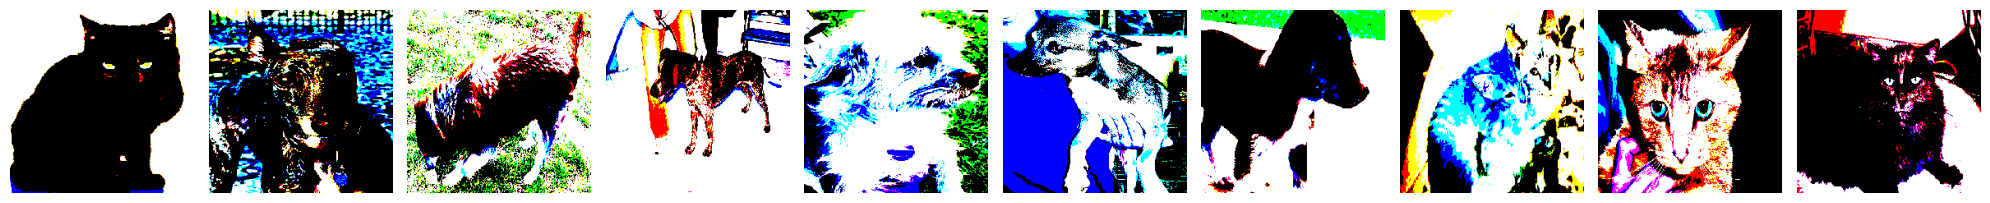

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [32]:
plot_images(imgs)
print(labels)

**BULID AND TRAIN a CNN**

In [39]:

model = Sequential([
    Input(shape=(224, 224, 3)),  # ✅ defines the input
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dense(units=2, activation='softmax')
])


In [40]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │       401,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,802 (1.61 MB)

 Trainable params: 420,802 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(optimizer= Adam(learning_rate = 0.0001),loss = 'categorical_crossentropy', metrics = ['accuracy'])
              

In [ ]:
model.fit(x= train_batches, validation_data = valid_batches, epochs=10, verbose=2)

C:\Users\babal\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
100/100 - 39s - 389ms/step - accuracy: 0.5510 - loss: 15.5482 - val_accuracy: 0.5850 - val_loss: 4.3040
Epoch 2/10
